# An investigation on AVO class 4.

A little investigation on the reliability of the values given in "Principles of AVO crossplotting" (Castagna et al., 1997, The Leading Edge) and "Framework for AVO Gradient and Intercept Interpretation" (Castagna et al., 1998, Geophysics).

All the AVO classes in one table:

facies        | AVO |  Vp   | Vs    | density | porosity
--------------|-----|-------|-------|---------|----------
shale         | 1   | 3094  | 1515  | 2.40    |
gas sand      | 1   | 4050  | 2526  | 2.21    | 0.20
brine sand    | 1   | 4115  | 2543  | 2.32    | 0.20
shale         | 2   | 2643  | 1167  | 2.29    |
gas sand      | 2   | 2781  | 1665  | 2.08    | 0.25
brine sand    | 2   | 3048  | 1595  | 2.23    | 0.25
shale         | 3   | 2192  | 818   | 2.16    |
gas sand      | 3   | 1543  | 901   | 1.88    | 0.33
brine sand    | 3   | 2134  | 860   | 2.11    | 0.33
shale         | 4   | 3240  | 1620  | 2.34    |
gas sand      | 4   | 1650  | 1090  | 2.07    | ?
brine sand    | 4   | 2590  | 1060  | 2.21    | ?


* Seismic Amplitude Interpretation, Hilterman, 2001, Distinguished Instructor Short Course, SEG
* Principles of AVO crossplotting, Castagna et al., 1997, The Leading Edge

**Porosity is unknown for class 4.**

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from avo_class_4_investigation_funcs import *

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100


#from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as ipw
from IPython.display import display

Put all the values above into Pandas DataFrames:

In [2]:
tmp_shale = np.array([[3094,1515,2.40,0], [2643,1167,2.29,0], [2192,818,2.16,0], [3240,1620,2.34,0]])
tmp_sandg = np.array([[4050,2526,2.21,.2], [2781,1665,2.08,.25], [1542,901,1.88,.33], [1650,1090,2.07,0]])
tmp_sandb = np.array([[4115,2453,2.32,.2], [3048,1595,2.23,.25], [2134,860,2.11,.33], [2590,1060,2.21,0]])
avocl = ['CLASS1', 'CLASS2', 'CLASS3', 'CLASS4']
logs = ['VP', 'VS', 'RHO', 'PHI']
shale = pd.DataFrame(tmp_shale, columns=logs, index=avocl)
sandg = pd.DataFrame(tmp_sandg, columns=logs, index=avocl)
sandb = pd.DataFrame(tmp_sandb, columns=logs, index=avocl)  

In [3]:
sandg

,VP,VS,RHO,PHI
CLASS1,4050.0,2526.0,2.21,0.20
CLASS2,2781.0,1665.0,2.08,0.25
CLASS3,1542.0,901.0,1.88,0.33
CLASS4,1650.0,1090.0,2.07,0.00


## Porosity from densities

$$
\phi = \frac{\rho - \rho_m} {\rho_f- \rho_m}
$$

In [4]:
rho_m = 2.65

print('STARTING POINT: BRINE SAND DENSITIES')
for i, ss in sandb.iterrows():
    rho_fluid = 1.0135
    phi = (ss['RHO'] - rho_m)/(rho_fluid - rho_m)
    itms = (ss.name, phi, ss.PHI)
    print('{:s}: calculated={:.2f}, given={:.2f}'.format(*itms))

print('\nSTARTING POINT: GAS SAND DENSITIES')
for i, ss in sandg.iterrows():
    rho_fluid = 0.32
    phi = (ss['RHO'] - rho_m)/(rho_fluid - rho_m)
    itms = (ss.name, phi, ss.PHI)
    print('{:s}: calculated={:.2f}, given={:.2f}'.format(*itms))

STARTING POINT: BRINE SAND DENSITIES
CLASS1: calculated=0.20, given=0.20
CLASS2: calculated=0.26, given=0.25
CLASS3: calculated=0.33, given=0.33
CLASS4: calculated=0.27, given=0.00

STARTING POINT: GAS SAND DENSITIES
CLASS1: calculated=0.19, given=0.20
CLASS2: calculated=0.24, given=0.25
CLASS3: calculated=0.33, given=0.33
CLASS4: calculated=0.25, given=0.00


## Porosity from densities

$$
\phi = \frac{\rho - \rho_m} {\rho_f- \rho_m}
$$

...for AVO Class 4, set $\phi=0.26$:

In [5]:
sandb.loc['CLASS4', 'PHI'] = 0.26
sandg.loc['CLASS4', 'PHI'] = 0.26

In [16]:
sandg

,VP,VS,RHO,PHI
CLASS1,4050.0,2526.0,2.21,0.20
CLASS2,2781.0,1665.0,2.08,0.25
CLASS3,1542.0,901.0,1.88,0.33
CLASS4,1650.0,1090.0,2.07,0.26


## porosity from Gassmann's equation

$$ \phi = \frac{(K_m - K_{satB}) \cdot (K_m - K_{satG}) \cdot (K_B - K_G)}{(K_m - K_B) \cdot (K_m - K_G) \cdot (K_{satB} - K_{satG})}$$

In [12]:
k_m = 37

k_w = 2.2
rho_w = 1.0

k_g = 0.02
rho_g = 0.32

In [13]:
avoclass = 'CLASS3'

vpG, vsG, rhoG, phi_given = sandg.loc[avoclass]
ksat_g = bulk(vpG, vsG, rhoG)

vpB, vsB, rhoB, _ = sandb.loc[avoclass]
ksat_b = bulk(vpB, vsB, rhoB)

phi = gassmann_phi(ksat_b, ksat_g, k_w, k_g, k_m)

print('Porosity: calculated={:.4f}, given={:.4f}'.format(phi, phi_given))

Porosity: calculated=0.3388, given=0.3300


In [22]:
def phi_from_gassmann(avoclass):
    vpG, vsG, rhoG, phi_given = sandg.loc[avoclass]
    ksat_g = bulk(vpG, vsG, rhoG)

    vpB, vsB, rhoB, _ = sandb.loc[avoclass]
    ksat_b = bulk(vpB, vsB, rhoB)

    phi = gassmann_phi(ksat_b, ksat_g, k_w, k_g, k_m)
    
    vp2, vs2, rho2, *_ = gassmann(vpB, vsB, rhoB, rho_w, k_w, rho_g, k_g, k_m, phi)
    
    print('Input (brine):     Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(vpB, vsB, rhoB))
    print('Reference (gas):   Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(vpG, vsG, rhoG))
    print('Output FRM gas:    Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(vp2, vs2, rho2))   
    itms = (percdiff(vpG, vp2), percdiff(vsG, vs2), percdiff(rhoG, rho2))
    print('Difference:        Vp={:+4.1%}, Vs={:+4.1%}, rho={:+4.1%}'.format(*itms))
    print('\nCalculated porosity:  {:.2f}'.format(phi))
    print('Given porosity:       {:.2f}'.format(phi_given))
    
    return phi

In [321]:
phi_from_gassmann('CLASS3');

Input (brine):     Vp=2134, Vs=860, rho=2.11
Reference (gas):   Vp=1542, Vs=901, rho=1.88
Output FRM gas:    Vp=1550, Vs=911, rho=1.88
Difference:        Vp=+0.5%, Vs=+1.1%, rho=-0.0%

Calculated porosity:  0.34
Given porosity:       0.33


In [322]:
phi_from_gassmann('CLASS4');

Input (brine):     Vp=2590, Vs=1060, rho=2.21
Reference (gas):   Vp=1650, Vs=1090, rho=2.07
Output FRM gas:    Vp=1643, Vs=1088, rho=2.10
Difference:        Vp=-0.4%, Vs=-0.2%, rho=+1.4%

Calculated porosity:  0.16
Given porosity:       0.26


In [326]:
def phi_finder(avoclass, rho_g, k_g, rho_w, k_w, k_m):
    phi_array = np.linspace(.1, .4)
   
    vpG, vsG, rhoG, phi_given = sandg.loc[avoclass]
    vpB, vsB, rhoB, _ = sandb.loc[avoclass]
    
    vp_0, vs_0, rho_0, ksat_0, kdry_0 = gassmann(vpG, vsG, rhoG, rho_g, k_g, rho_w, k_w, k_m, phi_array)
    vp_1, vs_1, rho_1, ksat_1, kdry_1 = gassmann(vpB, vsB, rhoB, rho_w, k_w, rho_g, k_g, k_m, phi_array)

    # find intersection and return porosity
    idx, val = find_nearest(kdry_0,kdry_1)
    phi_calc = phi_array[idx]
    
    f, ax = plt.subplots(figsize=(7, 5), constrained_layout=True)
    ax.plot(phi_array, kdry_0, '-r', lw=4, alpha=0.5, label='K_dry from gas')
    ax.plot(phi_array, kdry_1, '-b', lw=4, alpha=0.5, label='K_dry from brine')
    ax.axvline(phi_given, ls=':', color='k', label='Given phi={:.3f}'.format(phi_given))
    ax.plot(phi_calc, val, marker='o', mec='k', mfc='none', ms=15, ls='none', label='Calculated phi={:.3f}'.format(phi_calc))
    ax.set_xlabel('Porosity')
    ax.set_ylabel(r'$K_{dry}$ (GPa)')
    ax.legend(bbox_to_anchor=(1.01, 1))
    ax.set_ylim(-5, 25)
    ax.set_title(avoclass)

In [327]:
def reset_values(b):
    w_avoc.value = 'CLASS3'
    w_km.value = 37
    w_rhog.value = 0.3
    w_kg.value = 0.02
    w_rhow.value = 1.0
    w_kw.value = 2.2

sty = {'description_width': 'initial'}
w_avoc = ipw.ToggleButtons(value='CLASS3', description='AVO Class', options=['CLASS1', 'CLASS2', 'CLASS3', 'CLASS4'])
w_km = ipw.FloatSlider(value=37, description='K matrix (GPa)', max=40, min=30, step=1, style=sty)
w_rhog = ipw.FloatSlider(value=0.3, description='rho gas (g/cc)', max=0.4, min=0.1, step=0.05, style=sty)
w_kg = ipw.FloatSlider(value=0.02, description='K gas (GPa)', max=0.2, min=0.01, step=0.01, style=sty)
w_rhow = ipw.FloatSlider(value=1.0, description='rho water (g/cc)', max=1.1, min=0.9, step=0.05, style=sty)
w_kw = ipw.FloatSlider(value=2.2, description='K water (GPa)', max=3.5, min=2, step=0.05, style=sty)
reset_button = ipw.Button(description = "Reset")
reset_button.on_click(reset_values)

lbox = ipw.VBox([w_kg, w_rhog])
rbox = ipw.VBox([w_kw, w_rhow])
lrbox = ipw.HBox([lbox, rbox])
ui0 = ipw.VBox([w_avoc, w_km, lrbox, reset_button])

tool0 = ipw.interactive_output(phi_finder, {
    'avoclass': w_avoc,
    'rho_g': w_rhog,
    'k_g': w_kg,
    'rho_w': w_rhow,
    'k_w': w_kw,
    'k_m': w_km})

In [328]:
display(ui, tool)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 700x500 with 1 Axes>', 'i…

In [329]:
sandg

,VP,VS,RHO,PHI
CLASS1,4050.0,2526.0,2.21,0.20
CLASS2,2781.0,1665.0,2.08,0.25
CLASS3,1542.0,901.0,1.88,0.33
CLASS4,1650.0,1090.0,2.07,0.26


In [330]:
sandb

,VP,VS,RHO,PHI
CLASS1,4115.0,2453.0,2.32,0.20
CLASS2,3048.0,1595.0,2.23,0.25
CLASS3,2134.0,860.0,2.11,0.33
CLASS4,2590.0,1060.0,2.21,0.26


## Gassmann does not work

* porosity from density equation: 0.26
* porosity from Gassmann: 0.16
* is it realistic for a $\phi=0.16$ sand to increase its Vp of 940 m/s (+57%) going from gas to brine?

In [335]:
check_vpb = sandb.loc['CLASS4', 'VP']
check_vpg = sandg.loc['CLASS4', 'VP']
print(check_vpb-check_vpg)
print(percdiff(check_vpg, check_vpb))

940.0
0.5696969696969697


In [336]:
check_vpb = sandb.loc['CLASS3', 'VP']
check_vpg = sandg.loc['CLASS3', 'VP']
print(check_vpb-check_vpg)
print(percdiff(check_vpg, check_vpb))

592.0
0.383916990920882


* Class 3 sand with $\phi=0.33$ shows a +38% increase!
* ...if Gassmann does not work then one of the inputs must be wrong!

# pre-talk questions

* how long have you been involved with swung: august 2015
* what are you working on right now
* random fact the software underground may not know

to test:

http://jitsi.softwareunderground.org/

## find a justification for Class 4 numbers with Rock Physics Modeling

* Make Vp, Vs, rho using Soft Sand model on a range of porosities
* see if I match the input Vp, Vs, rho for AVO class 4 sand


In [357]:
def match_class4_rpm(avoclass, sigma, phic):
    # assign elastic properties for fluid (gas) and rock matrix
    Df, Kf = 0.3,  0.02
    Dqz, Kqz, Gqz = 2.65, 37, 44
    f=1

    # relation critical porosity-coordination number by Murphy (1982)
    # Mavko et al. (2009), The Rock Physics Handbook, Cambridge UP (p.246)
    Cn = 20-34*phic+14*phic**2

    # make vp, vs, rho for sand
    phi_dist = np.linspace(0.1, 0.4)
    ns = phi_dist.size
    Kdry, Gdry = softsand(Kqz, Gqz, phi_dist, sigma, phic, Cn, f)
    vp, vs, rho, _ = vels(Kdry, Gdry, Kqz, Dqz, Kf, Df, phi_dist)

    # get vp, vs, rho for class 4
    sand_vp, sand_vs, sand_rho, _ = sandg.loc[avoclass]
   
    # do the plot
    f, ax = plt.subplots(ncols=3, sharex=True, figsize=(8,4), constrained_layout=True)
    ax[0].plot(phi_dist, vp, '-k')
    ax[1].plot(phi_dist, vs, '-k')
    ax[2].plot(phi_dist, rho, '-k')
    ax[0].plot(0.26, sand_vp, 'or', alpha=0.5)
    ax[1].plot(0.26, sand_vs, 'or', alpha=0.5)
    ax[2].plot(0.26, sand_rho, 'or', alpha=0.5)
    ax[0].set_xlabel('Porosity')
    ax[0].set_ylabel('Vp (m/s)')
    ax[1].set_ylabel('Vs (m/s)')
    ax[2].set_ylabel('Density (g/cc)')

In [361]:
w_sigma = ipw.FloatSlider(value=20, description='Effective pressure (MPa)', max=40, min=5, step=5, style=sty)
w_phic = ipw.FloatSlider(value=0.3, description='Critical porosity', max=0.6, min=0.2, step=0.05, style=sty)
w_fudg = ipw.FloatSlider(value=1.0, description='Fudge factor', max=1.0, min=0., step=0.1, style=sty)

box = ipw.HBox([w_sigma, w_phic])
ui1 = ipw.VBox([w_avoc, box])
tool1 = ipw.interactive_output(match_class4_rpm, {
    'avoclass': w_avoc,
    'sigma': w_sigma,
    'phic': w_phic})
#    'f': w_fudg})

In [362]:
display(ui1, tool1)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 800x400 with 3 Axes>', 'i…

In [165]:
caprock_vp, caprock_vs, caprock_rho, _ = shale.loc['CLASS4']
sand_vp, sand_vs, sand_rho, _ = sandg.loc['CLASS3']
_, i_newcl4, g_newcl4 = shuey(caprock_vp, caprock_vs, caprock_rho, sand_vp, sand_vs, sand_rho, angs, terms=True)

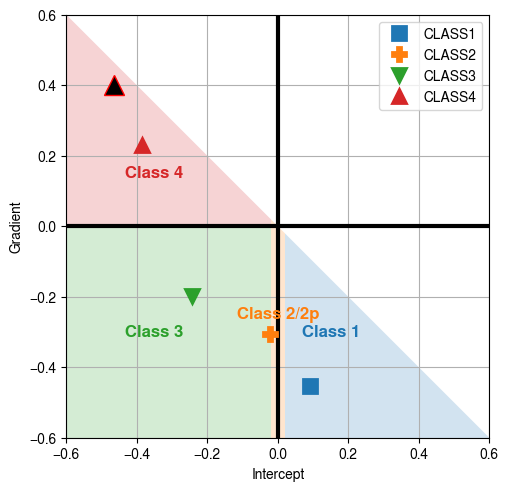

In [374]:
ax = classref(plot_brine=False)

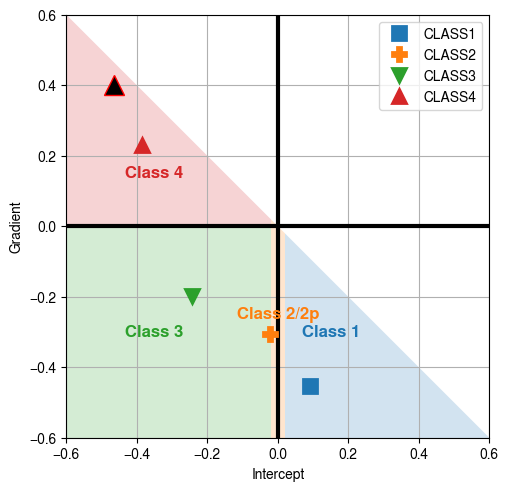

In [374]:
ax = classref(plot_brine=False)
ax.plot(i_newcl4, g_newcl4, '^', mec='r', mfc='k', ms=14)

# in short

* somebody would please ask John Castagna where those numbers come from?
* class 4 AVO is only peculiar because of what's above so:
    * take a class 3 sand
    * put class 4 shale on top
    * you still get something that plots in the right quadrant

* see if I find a way to validate those Vp, Vs, rho for Class 4 sand with some more rock physics modeling
* maybe set up optimization with `scipy.optimize.least_squares` and see if the parameters I get make sense

**notebook available here:** https://github.com/aadm/geophysical_notes

`avo_class_4_lightning_talk.ipynb`